<a href="https://colab.research.google.com/github/MatCat960/pf-training/blob/main/pf_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time

from copy import deepcopy as dc

In [ ]:
def insideFOV(robot, target, fov, range):
  fov_rad = fov * math.pi / 180.0
  xr = robot[0]
  yr = robot[1]
  phi = robot[2]
  dx = target[0] - xr
  dy = target[1] - yr
  dist = math.sqrt(dx**2 + dy**2)
  if dist > range:
    return 0

  xrel = dx * math.cos(phi) + dy * math.sin(phi)
  yrel = -dy * math.sin(phi) + dy * math.cos(phi)
  angle = abs(math.atan2(yrel, xrel))
  if (angle <= fov_rad) and (xrel >= 0.0):
    return 1
  else:
    return 0

In [ ]:
def plot_fov(fov_deg, radius, ax):
  # fig = plt.figure(figsize=(6,6))
  # plt.scatter(neighs[:, 0], neighs[:, 1], marker='*')

  x1 = np.array([0.0, 0.0, 0.0])
  fov = fov_deg * math.pi / 180
  arc_theta = np.arange(-0.5*fov, 0.5*fov, 0.01*math.pi)
  th = np.arange(fov/2, 2*math.pi+fov/2, 0.01*math.pi)

  # FOV
  xfov = radius * np.cos(arc_theta)
  xfov = np.append(x1[0], xfov)
  xfov = np.append(xfov, x1[0])
  yfov = radius * np.sin(arc_theta)
  yfov = np.append(x1[1], yfov)
  yfov = np.append(yfov, x1[1])
  ax.plot(xfov, yfov)

In [47]:
from numpy import linalg as LA

def plot_ellipse(ctr, cov, ax, s=4.605):
  """
  Args:
    ctr (np.array(1, 2)): center of the ellipse
    cov (np.array(2, 2)): covariance matrix
    s (double): confidence interval
  """

  epsilon = 0.01

  eigenvalues, eigenvectors = LA.eigh(cov)
  # eigenvalues = eigenvalues + epsilon
  # print(f"Eigenvalues: {eigenvalues}")
  # if eigenvalues[0] < 0.0 or eigenvalues[1] < 0.0:
  #   print(f"Cov matrix: {cov}")
  #   print(f"Eigenvalues: {eigenvalues}")
  # eigenvalues[eigenvalues < 0.0] = 0.1
  a = math.sqrt(s*abs(eigenvalues[0]))
  b = math.sqrt(s*abs(eigenvalues[1]))

  if (a < b):
    temp = dc(a)
    a = dc(b)
    b = temp

  print(f"Major axis: {a}")

  m = 0
  l = 1
  if eigenvalues[1] > eigenvalues[0]:
    m = 1
    l = 0

  theta = math.atan2(eigenvectors[1,m], eigenvectors[0,m])
  if theta < 0.0:
    theta += math.pi

  vx = []; vy = []
  x = ctr[0]
  y = ctr[1]
  for phi in np.arange(0, 2*np.pi, 0.1):
    xs = x + a * np.cos(phi) * np.cos(theta) - b * np.sin(phi) * np.sin(theta)
    ys = y + a * np.cos(phi) * np.sin(theta) + b * np.sin(phi) * np.cos(theta)
    vx.append(xs)
    vy.append(ys)

  vx.append(vx[0])
  vy.append(vy[0])

  # fig = plt.figure(figsize=(6,6))
  ax.plot(vx, vy)

In [223]:
class ParticleFilter():
  def __init__(self, particles_num, initState, initCovariance):
    """
      Particle Filter constructor
      Args:
        particles_num (int): number of particles
        initState (np.array): 2D or 3D coordinates array
        initCovariance (np.array): 2D or 3D array (considered as diagonal matrix)
    """
    self.n = particles_num
    self.state = initState
    self.covariance = initCovariance
    self.size = initState.size

    self.particles = np.zeros((self.size, self.n), dtype=float)
    self.weights = 1 / self.n * np.ones((self.n), dtype=float)
    print("Weights shape: {}".format(self.weights.shape))

    sigma_x = initCovariance[0]
    sigma_y = initCovariance[1]
    # sigma_th = initCovariance[2]

    for i in range(self.n):
      self.particles[0, i] = np.random.normal(self.state[0], sigma_x)
      self.particles[1, i] = np.random.normal(self.state[1], sigma_y)
      # self.particles[2, i] = np.random.normal(self.state[2], sigma_th)


  def setProcessCovariance(self, cov):
    """
    Set process covariance.
    Args:
      cov (np.array): 2D or 3D array (considered as diagonal matrix)
    """

    self.covariance = cov


  def predict(self, vel, dt=0.2):
    sigma_x = self.covariance[0]
    sigma_y = self.covariance[1]

    for i in range(self.n):
      x_next = self.particles[0, i] + vel[0]*dt
      y_next = self.particles[1, i] + vel[1]*dt

      self.particles[0, i] = np.random.normal(x_next, sigma_x)
      self.particles[1, i] = np.random.normal(y_next, sigma_y)

    self.mean = np.mean(self.particles)

  def predict2(self, mean, sigma):
    x_n = mean[0]
    y_n = mean[1]

    for i in range(self.n):
      self.particles[0, i] = np.random.normal(x_n, sigma)
      self.particles[1, i] = np.random.normal(y_n, sigma)

    self.mean = np.mean(self.particles)

  def getParticles(self):
    return self.particles

  def getWeights(self):
    return self.weights

  def getMean(self):
    return self.state

  def setWeights(self, weights):
    self.weights = weights

  def updateWeights(self, observation, sigma=0.01):
    """
    Update weigth from the detection of a neighbor. Detection is assumed to be accurate.
    """

    total_weight = 0.0
    for i in range(self.n):
      p = self.particles[:, i]
      obs = observation[:2]
      likelihood = math.exp(-0.5 * (math.pow(obs[0]-p[0], 2) / sigma**2 + (math.pow(obs[1]-p[1], 2)) / sigma**2))
      self.weights[i] = likelihood
      total_weight += likelihood

    # Normalize weights
    self.weigths = self.weights / total_weight

  def resample(self):

    normalized_weights = self.weights / np.sum(self.weights)
    nans = normalized_weights[np.isnan(normalized_weights)]
    if len(nans) > 0:
      print("Nan Values detected")
      print(f"Weights: {normalized_weights}")





    # Resampling step: randomly select particles with replacement based on their weights
    indices = np.random.choice(self.n, size=self.n, replace=True, p=normalized_weights)

    # Create a new set of particles based on the selected indices
    resampled_particles = self.particles[:, indices]
    resampled_weights = normalized_weights[indices]

    self.particles = resampled_particles
    self.weights = resampled_weights

    self.weights = self.weights / np.sum(self.weights)

    # print("Sum weights: {}")



## Robot's parameters

In [228]:
ROBOT_RANGE = 15.0
ROBOT_FOV = 120.0
AREA_SIZE = 40.0
NUM_PARTICLES = 2000
NUM_STEPS = 10

## Create log file

In [215]:
from pathlib import Path

path = Path("/content/drive/MyDrive/Colab Notebooks/PyTorch tutorial/pf_dataset_py")
file = path / "logfile.txt"
print(file)

/content/drive/MyDrive/Colab Notebooks/PyTorch tutorial/pf_dataset_py/logfile.txt


## Simulate robot motion

Weights shape: (500,)
Sum weights: {}
Major axis: 7.595640416256477e-14
Sum weights: {}
Major axis: 0.2722975726697458
Sum weights: {}
Major axis: 0.215989145833332
Sum weights: {}
Major axis: 2.2695039467745635
Sum weights: {}
Major axis: 3.2586583432086993
Sum weights: {}
Major axis: 3.8813603614121885
Sum weights: {}
Major axis: 4.568519626507049
Sum weights: {}
Major axis: 4.931624094670594
Sum weights: {}
Major axis: 5.327346582387338
Sum weights: {}
Major axis: 6.070188027687792


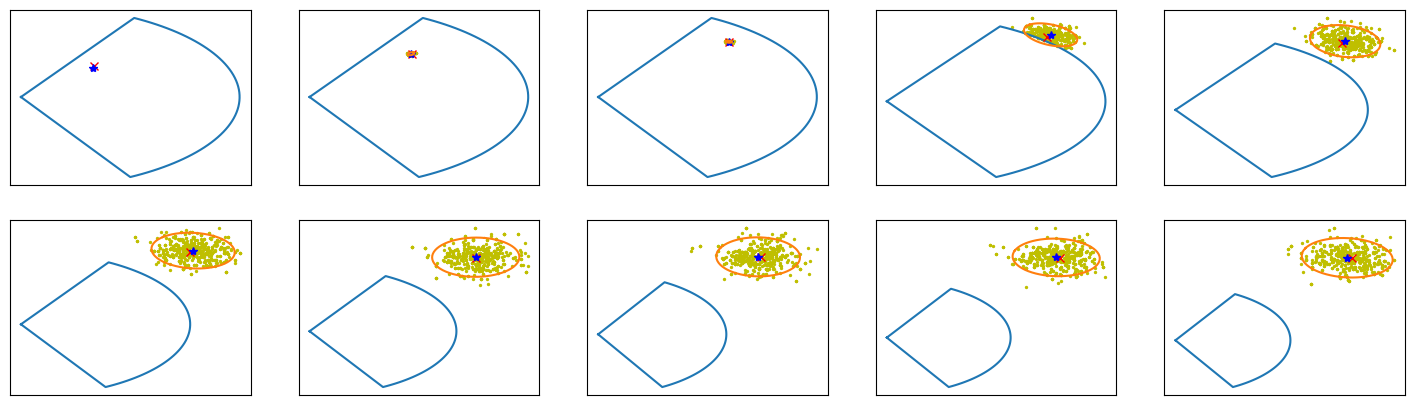

In [187]:
NUM_STEPS = 10
x0 = np.zeros(3)
initCov = 1.0*np.ones((3))

# Simulate ground truth motion
target = 5.0 * np.ones((NUM_STEPS, 2))
vel = 4.0
dt = 0.5
u = np.array([vel, vel])

for i in range(1, NUM_STEPS):
  target[i, 0] = target[i-1, 0] + vel * dt
  target[i, 1] = target[i-1, 1] + vel * dt


filter = ParticleFilter(NUM_PARTICLES, x0, initCov)
samples = filter.getParticles()

fig, axs = plt.subplots(2, 5, figsize=(18,5))

for i in range(NUM_STEPS):
  row = 0
  if i > 4:
    row = 1
  ax = axs[row,i-5*row]

  # check if target is inside

  if insideFOV(x0, target[i, :], ROBOT_FOV, ROBOT_RANGE):
    filter.predict(u, dt)
    # filter.predict2(target[i, :], 0.1)
    filter.updateWeights(target[i, :], 0.1)
  else:
    filter.predict(u, dt)
    # filter.predict2(target[i, :])
    samples = filter.getParticles()
    for j in range(NUM_PARTICLES):
      sample = samples[:, j]
      if insideFOV(x0, sample, ROBOT_FOV, ROBOT_RANGE):
        filter.weights[j] = 0.0

  filter.resample()

  parts = filter.getParticles()
  # mean = filter.getMean()
  cov = np.cov(parts)
  cov = cov[:2, :2]
  mean = np.mean(parts, 1)
  # print(f"Covariance: {cov}")

  plot_fov(ROBOT_FOV, ROBOT_RANGE, ax)
  ax.scatter(parts[0, :], parts[1, :], s=2.0, c='y')
  ax.plot(target[i, 0], target[i, 1], 'xr', label="Ground Truth")
  ax.plot(mean[0], mean[1], '*b')
  plot_ellipse(mean, cov, ax)
  ax.set_xticks([]); ax.set_yticks([])

In [244]:
import random
def move_random(pt):
  x = pt[0]
  y = pt[1]

  dx = random.uniform(-1, 1)
  dy = random.uniform(-1, 1)

  xn = x + dx
  yn = y + dy

  xn = max(-0.25*AREA_SIZE, min(xn, 0.75*AREA_SIZE))
  yn = max(-0.5*AREA_SIZE, min(yn, 0.5*AREA_SIZE))

  pt_new = np.array([xn, yn])

  return pt_new

def move_random_get_vel(pt):
  x = pt[0]
  y = pt[1]

  dx = random.uniform(-0.5, 0.5)
  dy = random.uniform(-0.5, 0.5)

  vel = np.array([dx, dy])

  xn = x + dx
  yn = y + dy

  xn = max(-0.25*AREA_SIZE, min(xn, 0.75*AREA_SIZE))
  yn = max(-0.5*AREA_SIZE, min(yn, 0.5*AREA_SIZE))

  pt_new = np.array([xn, yn])

  return pt_new, vel

In [251]:
NUM_STEPS = 1000
robot = np.zeros((2, NUM_STEPS), dtype=np.float)
vels = np.zeros((NUM_STEPS, 2))
print(robot.shape)
robot[0, 0] = 5.0
robot[1, 0] = 5.0
vel = 1.0
dt = 1.0
u = np.array([vel, vel])
x0 = np.zeros(3)
initCov = 1.0*np.ones((2))
for i in range(1, NUM_STEPS):
  robot[:, i], vels[i, :] = move_random_get_vel(robot[:, i-1])

filter = ParticleFilter(NUM_PARTICLES, x0[:2], initCov)
samples = filter.getParticles()

# fig, axs = plt.subplots(2, 5, figsize=(18,5))

means_log = []

for i in range(NUM_STEPS):
  # row = 0
  # if i > 4:
  #   row = 1
  # ax = axs[row,i-5*row]

  # check if target is inside

  if insideFOV(x0, robot[:, i], ROBOT_FOV, ROBOT_RANGE):
    # filter.setProcessCovariance(0.1*np.ones(3))
    filter.predict(vels[i, :], dt)
    filter.updateWeights(robot[:,i], 0.1)
  else:
    # filter.setProcessCovariance(np.ones(3))
    filter.predict(vels[i, :], dt)
    samples = filter.getParticles()
    for j in range(NUM_PARTICLES):
      sample = samples[:, j]
      if insideFOV(x0, sample, ROBOT_FOV, ROBOT_RANGE):
        filter.weights[j] = 0.0

  # print(f"Iteration num. {i}")
  filter.resample()

  parts = filter.getParticles()
  # mean = filter.getMean()
  cov = np.cov(parts)
  cov = cov[:2, :2]
  cov = cov.reshape(-1, 4)
  mean = np.mean(parts, 1)
  mean = mean.reshape(1, 2)
  mean = mean.squeeze(0)
  cov = cov.squeeze(0)
  means_log.append(mean)

  # print(mean.shape)
  # print(cov.shape)
  r = robot[:, i]
  txt_arr = np.hstack((r, cov))
  # txt = np.array2string(txt_arr)
  txt = ""
  for elem in txt_arr:
    txt += str(elem) + " "
  txt += '\n'


  with open(str(file), 'a') as f:
    f.writelines(txt)
  # print(f"Covariance: {cov}")

  # plot_fov(ROBOT_FOV, ROBOT_RANGE, ax)
  # ax.scatter(parts[0, :], parts[1, :], s=2.0, c='y')
  # ax.plot(target[i, 0], target[i, 1], 'xr', label="Ground Truth")
  # ax.plot(mean[0], mean[1], '*b')
  # plot_ellipse(mean, cov, ax)
  # ax.set_xticks([]); ax.set_yticks([])

<ipython-input-251-1087c9b9c498>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  robot = np.zeros((2, NUM_STEPS), dtype=np.float)


(2, 1000)
Weights shape: (2000,)


array([31.64168583, 35.06429577, -0.66305205])

Major axis: 0.2513390413271717


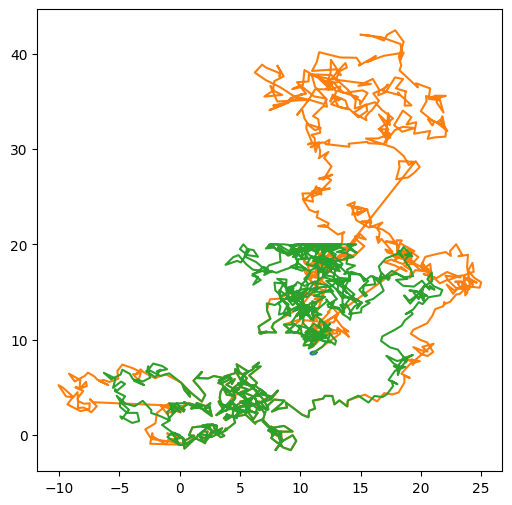

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_ellipse(mean, cov.reshape(2,2), ax)
m = np.array(means_log)
plt.plot(m[:, 0], m[:, 1])
plt.plot(robot[0, :], robot[1, :])